In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
import glob
import re
import itertools
import time
import joblib
import random
import itertools
import pickle

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.lines import Line2D

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

from sklearn.datasets import load_boston
from upsetplot import UpSet, from_contents

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
#from polyfuse.configs.igsb_jupyter import config
parsl.load(config)

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/cancer_cell_lines/processed'
model_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/models'

In [7]:
samples_and_fusions = [
    ('BT474', 'ACACA--STAC2'),
    ('BT474', 'AHCTF1--NAAA'),
    ('BT474', 'CPNE1--PI3'),
    ('BT474', 'DIDO1--TTI1'),
    ('BT474', 'FAM102A--CIZ1'),
    ('BT474', 'GLB1--CMTM7'),
    ('BT474', 'LAMP1--MCF2L'),
    ('BT474', 'LIMA1--USP22'),
    ('BT474', 'MED1--ACSF2'),
    ('BT474', 'MED1--STXBP4'),
    ('BT474', 'MED13--BCAS3'),
    ('BT474', 'PIP4K2B--RAD51C'),
    ('BT474', 'RAB22A--MYO9B'),
    ('BT474', 'RPS6KB1--SNF8'),
    ('BT474', 'SKA2--MYO19'),
    ('BT474', 'STARD3--DOK5'),
    ('BT474', 'STX16--RAE1'),
    ('BT474', 'THRA--AC090627.1'),
    ('BT474', 'TOB1--SYNRG'),
    ('BT474', 'TRPC4AP--MRPL45'),
    ('BT474', 'USP32--MED1'),
    ('BT474', 'VAPB--IKZF3'),
    ('BT474', 'ZMYND8--CEP250'),
    ('KPL4', 'BSG--NFIX'),
    ('KPL4', 'NOTCH1--NUP214'),
    ('KPL4', 'PPP1R12A--SEPT10'),
    ('MCF7', 'AC099850.1--VMP1'),
    ('MCF7', 'ADAMTS19--SLC27A6'),
    ('MCF7', 'AHCYL1--RAD51C'),
    ('MCF7', 'ARFGEF2--SULF2'),
    ('MCF7', 'ARHGAP19--DRG1'),
    ('MCF7', 'ATXN7L3--FAM171A2'),
    ('MCF7', 'BCAS4--BCAS3'),
    ('MCF7', 'GCN1L1--MSI1'),
    ('MCF7', 'MYH9--EIF3D'),
    ('MCF7', 'MYO9B--FCHO1'),
    ('MCF7', 'PAPOLA--AK7'),
    ('MCF7', 'RPS6KB1--DIAPH3'),
    ('MCF7', 'RPS6KB1--VMP1'),
    ('MCF7', 'SMARCA4--CARM1'),
    ('MCF7', 'SULF2--PRICKLE2'),
    ('SKBR3', 'ANKHD1--PCDH1'),
    ('SKBR3', 'CCDC85C--SETD3'),
    ('SKBR3', 'CSE1L--AL035685.1'),
    ('SKBR3', 'CYTH1--EIF3H'),
    ('SKBR3', 'DHX35--ITCH'),
    ('SKBR3', 'KLHDC2--SNTB1'),
    ('SKBR3', 'NFS1--PREX1'),
    ('SKBR3', 'PREX1--CPNE1'),
    ('SKBR3', 'RARA--PKIA'),
    ('SKBR3', 'SUMF1--LRRFIP2'),
    ('SKBR3', 'TATDN1--GSDMB'),
    ('SKBR3', 'WDR67--ZNF704')
]

truth = pd.DataFrame(data={
    'sample': [e[0] for e in samples_and_fusions],
    'fusion': [e[1] for e in samples_and_fusions]
    }
)
truth.to_hdf(os.path.join(out_dir, 'true_fusions.hdf'), 'data')

In [8]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [9]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [10]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [11]:
samples = sorted(caller_data['sample'].unique())

In [12]:
start = time.time()
x, y = apps.assemble_data(samples, callers, out_dir, assemble_truth=False)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 12.6s


In [149]:
start = time.time()
with open(os.path.join(model_dir, 'classifiers.pkl'), 'rb') as f:
    classifiers = pickle.load(f)

consensus_data = pd.read_hdf(
    apps.predict_consensus(samples, out_dir, callers, [3, 4, 5, 6, 7]), 'data'
)
print('assembled consensus predictions in {:.1f}s'.format((time.time() - start)))

start = time.time()
consensus = ['ConsensusQ5', 'ConsensusQ4', 'ConsensusQ3']
model_data = pd.read_hdf(
    apps.predict(samples, out_dir, model_dir, classifiers, callers, consensus=consensus), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled consensus predictions in 5.2s
assembled predictions in 24.3s


In [150]:
pd.options.display.max_rows = None
model_data[(model_data.caller == 'PolyfuseGBC19F') & (model_data.prediction == 1)]

,sample,caller,fusion,probability,prediction


In [151]:
summary = apps.make_summary(out_dir, samples)

In [152]:
pd.options.display.max_rows = None
summary.groupby('caller').mean().sort_values(by='tp', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
ConsensusQ3PolyfuseGBC18F,12.50,8.50,0.75,341.00,0.950,0.539,0.971,0.671,0.694
ConsensusQ3PolyfuseDefaultGBC18F,12.50,8.50,0.75,341.00,0.950,0.542,0.971,0.676,0.697
ConsensusQ4PolyfuseDefaultGBC18F,12.00,7.25,1.25,342.25,0.922,0.571,0.974,0.691,0.706
ConsensusQ4PolyfuseGBC18F,12.00,7.25,1.25,342.25,0.922,0.567,0.974,0.684,0.702
ConsensusQ5PolyfuseGBC18F,11.75,6.75,1.50,342.75,0.906,0.579,0.974,0.690,0.703
PolyfuseDefaultGBC18F,11.75,6.75,1.50,342.75,0.906,0.585,0.975,0.699,0.710
ConsensusQ5PolyfuseDefaultGBC18F,11.75,6.75,1.50,342.75,0.906,0.585,0.975,0.699,0.710
PolyfuseGBC18F,11.50,6.75,1.75,342.75,0.895,0.577,0.974,0.684,0.697
starfusion,10.00,9.25,3.25,340.25,0.716,0.457,0.961,0.544,0.546


In [153]:
pd.options.display.max_rows = None
for sample in samples:
    print(summary.loc[summary['sample'] == sample, ['sample', 'caller', 'tp', 'fp', 'fn', 'tn']].sort_values(by='tp', ascending=False))

   sample                            caller  tp   fp  fn   tn
12  BT474  ConsensusQ3PolyfuseGBC18F         23  7    0   431
28  BT474  ConsensusQ3PolyfuseDefaultGBC18F  23  7    0   431
8   BT474  ConsensusQ4PolyfuseGBC18F         22  6    1   432
16  BT474  PolyfuseDefaultGBC18F             22  5    1   433
20  BT474  ConsensusQ5PolyfuseDefaultGBC18F  22  5    1   433
24  BT474  ConsensusQ4PolyfuseDefaultGBC18F  22  6    1   432
4   BT474  ConsensusQ5PolyfuseGBC18F         22  5    1   433
0   BT474  PolyfuseGBC18F                    21  5    2   433
56  BT474  ConsensusQ3                       21  6    2   0  
44  BT474  starfusion                        21  9    2   429
36  BT474  starseqr                          20  31   3   407
48  BT474  arriba                            20  54   3   384
52  BT474  pizzly                            20  353  3   85 
60  BT474  ConsensusQ4                       19  3    4   3  
32  BT474  fusioncatcher                     17  6    6   432
64  BT47

/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect

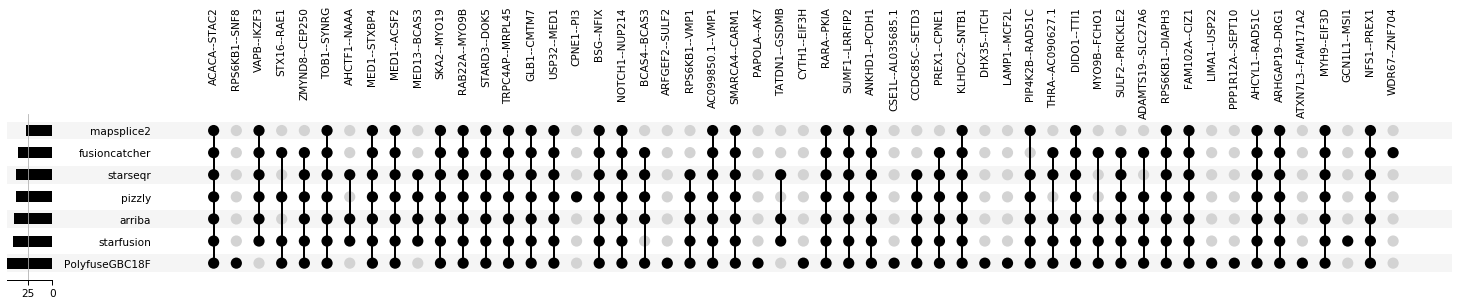

In [202]:
data = pd.concat([caller_data, model_data[(model_data.caller == 'PolyfuseGBC18F') & (model_data.prediction == 1)]])
contents = {}
for caller in data.caller.unique():
    called_fusions = []
    for sample in samples:
        sample_fusions = data[(data.caller == caller) & (data['sample'] == sample)].fusion.unique()
        sample_truth = truth[truth['sample'] == sample]
        called_fusions += [f for f in sample_fusions if any(sample_truth.fusion.isin([f]))]
    contents[caller] = [f for f in called_fusions if any(truth.fusion.isin([f]))]
not_called = set(truth.fusion).difference(set(sum(contents.values(), [])))
if len(not_called) > 0:
    contents['not called'] = not_called

upset = UpSet(from_contents(contents), subset_size='count', intersection_plot_elements=3, sort_by='cardinality') #, orientation='vertical')
#upset = UpSet(from_contents(contents), subset_size='count', intersection_plot_elements=3)
upset.plot()
plt.savefig('plots/cancer_cell_lines.pdf')

In [178]:
upset._df.id.values

array(['ACACA--STAC2', 'RPS6KB1--SNF8', 'VAPB--IKZF3', 'STX16--RAE1',
       'ZMYND8--CEP250', 'TOB1--SYNRG', 'AHCTF1--NAAA', 'MED1--STXBP4',
       'MED1--ACSF2', 'MED13--BCAS3', 'SKA2--MYO19', 'RAB22A--MYO9B',
       'STARD3--DOK5', 'TRPC4AP--MRPL45', 'GLB1--CMTM7', 'USP32--MED1',
       'CPNE1--PI3', 'BSG--NFIX', 'NOTCH1--NUP214', 'BCAS4--BCAS3',
       'ARFGEF2--SULF2', 'RPS6KB1--VMP1', 'AC099850.1--VMP1',
       'SMARCA4--CARM1', 'PAPOLA--AK7', 'TATDN1--GSDMB', 'CYTH1--EIF3H',
       'RARA--PKIA', 'SUMF1--LRRFIP2', 'ANKHD1--PCDH1',
       'CSE1L--AL035685.1', 'CCDC85C--SETD3', 'PREX1--CPNE1',
       'KLHDC2--SNTB1', 'DHX35--ITCH', 'LAMP1--MCF2L', 'PIP4K2B--RAD51C',
       'THRA--AC090627.1', 'DIDO1--TTI1', 'MYO9B--FCHO1',
       'SULF2--PRICKLE2', 'ADAMTS19--SLC27A6', 'RPS6KB1--DIAPH3',
       'FAM102A--CIZ1', 'LIMA1--USP22', 'PPP1R12A--SEPT10',
       'AHCYL1--RAD51C', 'ARHGAP19--DRG1', 'ATXN7L3--FAM171A2',
       'MYH9--EIF3D', 'GCN1L1--MSI1', 'NFS1--PREX1', 'WDR67--ZNF704'],
  

In [56]:
len(set(sum(contents.values(), [])))

43

In [148]:
caller = 'PolyfuseGBC19F'
called_fusions = data[data.caller == caller].fusion.unique()
len(called_fusions)

80